## Bag of words 

In [2]:
import numpy as np
import pandas as pd
import itertools
from pathlib import Path

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression
from sklearn import metrics as m

from matplotlib import pyplot as plt
from matplotlib.patches import Patch
from matplotlib.colors import ListedColormap

processed_data_path = Path('../data/processed/std_socialmedia_relevant_cols.csv')
df = pd.read_csv(processed_data_path)
SEED = 10

Building bag-of-words with TF-IDF

In [5]:
tfidf_vectorizer = TfidfVectorizer()

list_corpus = df['text'].tolist()
list_labels = df['class_label'].tolist()

X_train, X_test, y_train, y_test = train_test_split(
    list_corpus,
    list_labels,
    test_size=0.2,
    random_state=SEED
)

X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

Visualizing the vocabulary

In [6]:
def lsa(data, labels, plot=False, savepath='../imgs/lsa_plot.jpg'):
    lsa_model = TruncatedSVD(n_components=2)
    lsa_model.fit(data)
    lsa_scores = lsa_model.transform(data)
    color_mapper = {label: index for index, label in enumerate(set(labels))}
    color_column = [color_mapper[label] for label in labels]
    colors = ['orange', 'blue', 'blue']
    if plot:
        fig = plt.figure(figsize=(10,10))
        plt.scatter(
            lsa_scores[:,0],
            lsa_scores[:,1],
            s=8,
            alpha=0.8,
            c=labels,
            cmap=ListedColormap(colors=colors)
        )
        red_patch = Patch(color='orange', label='irrelevant')
        green_patch = Patch(color='blue', label='disaster')
        plt.legend(handles=[red_patch, green_patch], prop={'size':20})
        plt.show()
        plt.savefig(savepath)

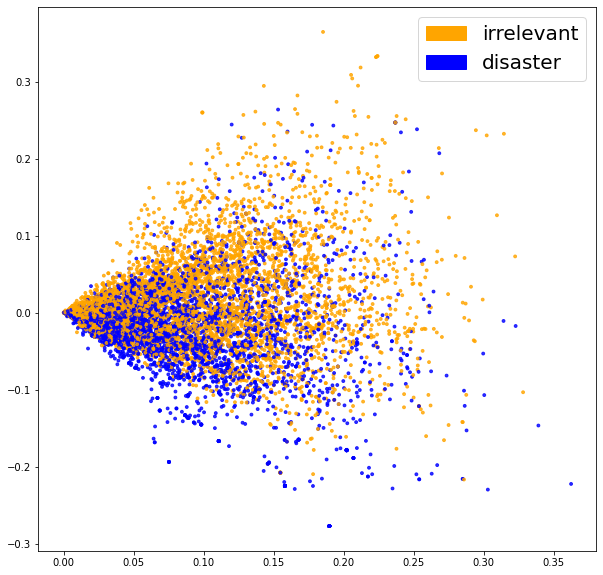

<Figure size 432x288 with 0 Axes>

In [7]:
lsa(X_train_tfidf, y_train, plot=True)

Training the classifier

In [8]:
clf = LogisticRegression(
    C=30,
    class_weight='balanced',
    solver='newton-cg',
    multi_class='multinomial',
    n_jobs=-1,
    random_state=SEED
)
clf.fit(X_train_tfidf, y_train)
y_predicted_tfidf = clf.predict(X_test_tfidf)

Evaluating the classifier

Métricas de avaliação:

$$Precision = \frac{TP}{TP + FP}$$
$$Recall = \frac{TP}{TP + FN}$$
$$F_1 = 2 \cdot \frac{Precision \cdot Recall}{Precision + Recall}$$
$$Accuracy = \frac{TP + TF}{Total}$$

In [9]:
def get_metrics(y_test, y_predicted):
    precision = m.precision_score(
        y_test,
        y_predicted,
        pos_label=None,
        average='weighted'
    )
    recall = m.recall_score(
        y_test,
        y_predicted,
        pos_label=None,
        average='weighted'
    )
    f1 = m.f1_score(
        y_test,
        y_predicted,
        pos_label=None,
        average='weighted'
    )
    acc = m.accuracy_score(y_test, y_predicted)
    
    return acc, precision, recall, f1

In [11]:
acc, precision, recall, f1 = get_metrics(y_test, y_predicted_tfidf)
print(f'accuracy = {acc:.3f}, precision = {precision:.3f}, recall = {recall:.3f}, f1 = {f1:.3f}')

accuracy = 0.799, precision = 0.797, recall = 0.799, f1 = 0.798


/home/aizen/dev/atlantico-academy/cognitive-comp/cognitive-comp/dsm/.venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Creating a confusion matrix

In [12]:
def plot_confusion_matrix(
    cm,
    classes,
    normalize=False,
    title='Confusion Matrix',
    cmap=plt.cm.winter
):
    if normalize:
        cm = cm.astype('float')/cm.sum(axis=1)[:, np.newaxis]
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=20)
    plt.yticks(tick_marks, classes, fontsize=20)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(
            j,
            i,
            format(cm[i, j], fmt),
            horizontalalignment='center',
            color='white' if cm[i, j] < thresh else 'black',
            fontsize=40
        )
        plt.tight_layout()
        plt.ylabel('True label', fontsize=30)
        plt.xlabel('Predicted label', fontsize=30)
    return plt

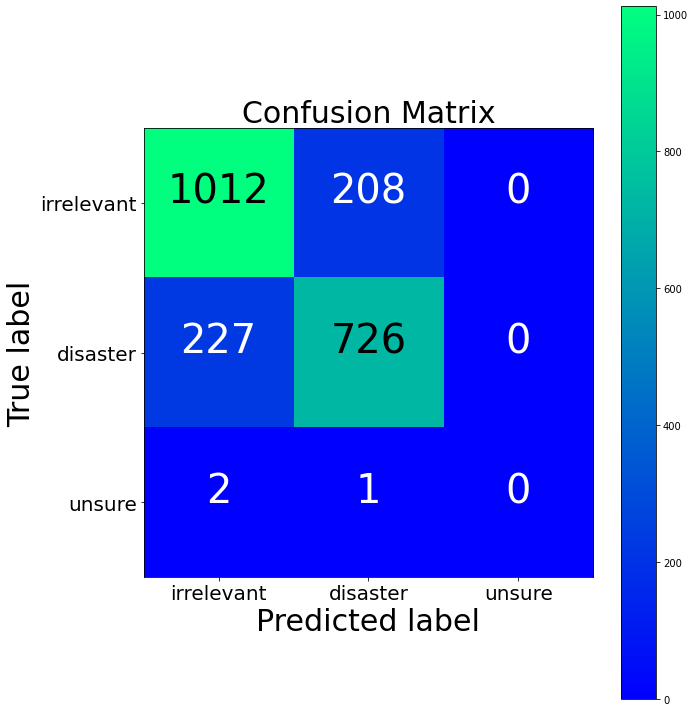

TF-IDF Confusion Matrix
[[1012  208    0]
 [ 227  726    0]
 [   2    1    0]]


In [13]:
cm = m.confusion_matrix(y_test, y_predicted_tfidf)
fig = plt.figure(figsize=(10, 10))
plot = plot_confusion_matrix(
    cm,
    classes=['irrelevant', 'disaster', 'unsure'],
    normalize=False,
    title='Confusion Matrix'
)
plt.show()
print('TF-IDF Confusion Matrix')
print(cm)

Method to identifying the most important features in the desicion making

In [15]:
def get_most_important_features(vectorizer, model, n=5):
    index_to_word = {v: k for k, v in vectorizer.vocabulary_.items()}
    # Loop for each class
    classes = {}
    for class_index in range(model.coef_.shape[0]):
        word_importances = [
            (el, index_to_word[i])
            for i, el in enumerate(model.coef_[class_index])
        ]
        sorted_coeff = sorted(
            word_importances,
            key=lambda x: x[0], reverse=True
        )
        tops = sorted(sorted_coeff[:n], key=lambda x: x[0])
        bottom = sorted_coeff[-n:]
        classes[class_index] = {'tops': tops, 'bottom': bottom}
    return classes

In [ ]:
importance = get_most_important_features(tfidf_vectorizer, clf, 10)

Method to plot the most important features

In [15]:
def plot_important_words(
    top_scores,
    top_words,
    bottom_scores,
    bottom_words,
    name
):
    y_pos = np.arange(len(top_words))
    top_pairs = sorted(
        [(a,b) for a,b in zip(top_words, top_scores)],
        key=lambda x: x[1]
    )
    bottom_pairs = sorted(
        [(a,b) for a,b in zip(bottom_words, bottom_scores)],
        key=lambda x: x[1], reverse=True
    )
    top_words_ = [a[0] for a in top_pairs]
    top_scores_ = [a[1] for a in top_pairs]
    bottom_words_ = [a[0] for a in bottom_pairs]
    bottom_scores_ = [a[1] for a in bottom_pairs]
    
    fig = plt.figure(figsize=(10, 10))
    plt.subplot(121)
    plt.barh(
        y_pos,
        bottom_scores_,
        align='center',
        alpha=0.5
    )
    plt.title('irrelevant', fontsize=16)
    plt.yticks(y_pos, bottom_words_, fontsize=12)
    plt.suptitle('Key words', fontsize=14)
    plt.xlabel('Importance', fontsize=16)
    
    plt.subplot(122)
    plt.barh(
        y_pos,
        top_scores_,
        align='center',
        alpha=0.5
    )
    plt.title('disaster', fontsize=16)
    plt.yticks(y_pos, top_words_, fontsize=12)
    plt.suptitle('Importance', fontsize=16)
    plt.subplots_adjust(wspace=0.8)
    plt.show()

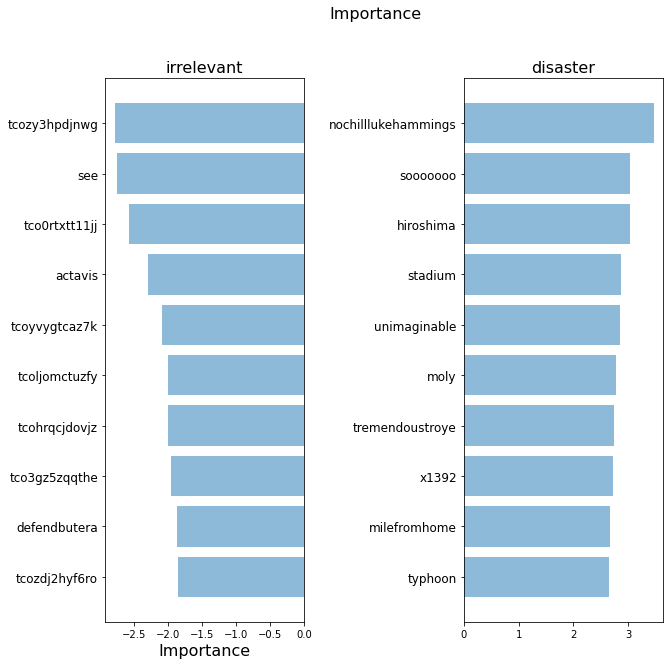

In [16]:
top_scores = [a[0] for a in importance[1]['tops']]
top_words = [a[1] for a in importance[1]['tops']]
bottom_scores = [a[0] for a in importance[1]['bottom']]
bottom_words = [a[1] for a in importance[1]['bottom']]
plot_important_words(
    top_scores,
    top_words,
    bottom_scores,
    bottom_words,
    'Most important words for relevance'
)